In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm 
from discopro.grammar import tensor
from lambeq import BobcatParser, NumpyModel, AtomicType, Rewriter, Dataset, QuantumTrainer, SPSAOptimizer , AtomicType, IQPAnsatz, RemoveCupsRewriter
from lambeq.backend.grammar import Spider
from lambeq.rewrite import UnifyCodomainRewriter
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Ty
from tqdm import tqdm
import random
import datetime
from discopro.anaphora import connect_anaphora_on_top
from contextuality.model import Model, Scenario, CyclicScenario
from lambeq.backend.quantum import Box, qubit, SelfConjugate, Ry, Diagram
import sys

In [2]:
remove_cups = RemoveCupsRewriter()

parser = BobcatParser()
rewriter = Rewriter(['auxiliary',
                     'connector',
                     'coordination',
                     'determiner',
                     'object_rel_pronoun',
                     'subject_rel_pronoun',
                     'postadverb',
                     'preadverb',
                     'prepositional_phrase'])

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE 

ansatz = IQPAnsatz({N: 1, S: 1, P:1}, n_layers=1, n_single_qubit_params=3) 

In [3]:
def generate_diagram(diagram, pro, ref):

    pro_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == pro.casefold())
    ref_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == ref.casefold())
    final_diagram = connect_anaphora_on_top(diagram, pro_box_idx, ref_box_idx)
    rewritten_diagram = rewriter(remove_cups(final_diagram)).normal_form()
    return rewritten_diagram

In [4]:
def sent2dig(sentence1: str, sentence2: str, pro: str, ref: str):
    diagram1 = parser.sentence2diagram(sentence1)
    diagram2 = parser.sentence2diagram(sentence2)
    diagram = tensor(diagram1,diagram2)
    #diagram = diagram >> Spider(S, 2, 1)
    diagram = generate_diagram(diagram, pro, ref)
    #merger = UnifyCodomainRewriter(Ty('s'))
    #diagram = merger(diagram)
    return diagram

In [5]:
def gen_labels(df: pd.DataFrame):
    circuits, labels, diagrams = [],[],[]
    #selected_cols = [random.choice(['referent', 'wrong_referent']) for i in range(len(df))]
    for i, row in tqdm(df.iterrows(), total=len(df), position=0, leave=True):
        #ref = row[selected_cols[i]]
        # label = [[0.25, 0.25],[0.25, 0.25]] if selected_cols[i] == 'referent' else [[0.25, 0.25],[0.25, 0.25]]
        # sent1, sent2, pro = row[['sentence1', 'sentence2', 'pronoun']]
        label = [[0.25, 0.25],[0.25, 0.25]]
        sent1, sent2, pro, ref = row[['sentence1', 'sentence2', 'pronoun', 'referent']]

        try:
            diagram = sent2dig(sent1.strip(), sent2.strip(), pro.strip(), ref.strip())
            diagrams.append(diagram)
            circ = ansatz(diagram)
            circuits.append(circ)
            labels.append(label)
        except Exception as e:
            tqdm.write(f"Error: {e}".strip(), file=sys.stderr)
    return circuits, labels, diagrams

In [6]:
df_train = pd.read_csv('dataset/original_data/train.csv', index_col=0)
df_val = pd.read_csv('dataset/original_data/val.csv', index_col=0)
df_test = pd.read_csv('dataset/original_data/test.csv', index_col=0)

In [59]:
train_circuits, train_labels, train_diagrams = gen_labels(df_train[:10])
val_circuits, val_labels, val_diagrams = gen_labels(df_val[:10])
test_circuits, test_labels, test_diagrams = gen_labels(df_test[:10])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.45it/s]
Error: Diagram 0 (cod=n @ n.r @ n @ n) does not compose with diagram 1 (dom=n @ p.r @ n)                                                                 
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                      
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.72it/s]
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                      
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                      
100%|███████████████████████████████████████████████████████████████████████

In [129]:
from lambeq.training import BinaryCrossEntropyLoss
all_circuits = train_circuits + val_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
loss = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y: np.sqrt(np.mean((y_hat-y)**2)/2)
eval_metrics = {"err": acc}

In [126]:
def main(EPOCHS: int, SEED: int, BATCH_SIZE: int) -> None:

    trainer = QuantumTrainer(
        model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams={'a': 0.1, 'c': 0.06, 'A': 0.01 * EPOCHS},
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

    train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
    val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

    now = datetime.datetime.now()
    t = now.strftime("%Y-%m-%d_%H_%M_%S")
    print(t)
    trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=1, eval_mode='step')
    test_acc = acc(model(test_circuits), test_labels)
    print('Test accuracy:', test_acc)

In [127]:
SEED = random.choice([0, 10, 50, 77, 100, 111, 150, 169, 200, 234, 250, 300, 350, 400, 450])
BATCH_SIZE = 20
EPOCHS = 100

In [128]:
main(EPOCHS, SEED, BATCH_SIZE)

2024-07-02_15_51_18


Step 1:    train/loss: 1.0953   valid/loss: 0.8753   train/err: 0.1547   valid/err: 0.1691
Step 2:    train/loss: 1.1385   valid/loss: 0.8726   train/err: 0.1631   valid/err: 0.1663
Step 3:    train/loss: 1.1453   valid/loss: 0.8760   train/err: 0.1428   valid/err: 0.1297
Step 4:    train/loss: 0.9840   valid/loss: 0.8703   train/err: 0.1494   valid/err: 0.1336
Step 5:    train/loss: 0.9367   valid/loss: 0.9013   train/err: 0.1567   valid/err: 0.1471
Step 6:    train/loss: 0.8575   valid/loss: 0.9530   train/err: 0.1746   valid/err: 0.1565
Step 7:    train/loss: 0.8465   valid/loss: 0.9505   train/err: 0.1487   valid/err: 0.1582
Step 8:    train/loss: 0.9257   valid/loss: 0.9419   train/err: 0.1588   valid/err: 0.1272
Step 9:    train/loss: 0.9050   valid/loss: 1.1418   train/err: 0.1556   valid/err: 0.1526
Step 10:   train/loss: 0.8718   valid/loss: 1.1471   train/err: 0.1486   valid/err: 0.1527
Step 11:   train/loss: 0.8723   valid/loss: 1.0463   train/err: 0.1492   valid/err: 0.1563

TypeError: unsupported operand type(s) for -: 'ArrayImpl' and 'list'

In [12]:
def gen_emp(diags: [Diagram], model: NumpyModel) -> Model:
    scenario = CyclicScenario(['a','b','A','B'],2)
    prob_dist = []
    for diag in diags:
        prob_dist.append(model.get_diagram_output([diag])[0].flatten())
    return Model(scenario, prob_dist)

In [13]:
best_model = NumpyModel.from_checkpoint('runs/Jul02_12-46-52_smew.cs.ucl.ac.uk/best_model.lt')
best_model.initialise_weights()

In [35]:
res = []
x = df_test[:100]
for i, row in tqdm(x.iterrows(), total=len(x)):
    try:
        s1, s2, p, n = row[['sentence1','sentence2','pronoun','referent']]
        diag = ansatz(sent2dig(s1, s2, p, n))
        
        diagXX = diag.apply_gate(Ry(0),0)
        diagXX = diagXX.apply_gate(Ry(np.pi/8),1)
        
        diagXZ = diag.apply_gate(Ry(0),0)
        diagXZ = diagXZ.apply_gate(Ry(3*np.pi/8),1)
        
        diagZX = diag.apply_gate(Ry(np.pi/4),0)
        diagZX = diagZX.apply_gate(Ry(np.pi/8),1)
        
        diagZZ = diag.apply_gate(Ry(np.pi/4),0)
        diagZZ = diagZZ.apply_gate(Ry(3*np.pi/8),1)
        
        emp_model = gen_emp([diagXX, diagXZ, diagZX, diagZZ], best_model)
        
        # res.append((emp_model.contextual_fraction(),
        #               emp_model.signalling_fraction(),
        #               emp_model.CbD_direct_influence(),
        #               emp_model.CbD_measure()))
        res.append(emp_model)
    except Exception as e:
        tqdm.write(f"Error: {e}".strip(), file=sys.stderr)

Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                      
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                      
Error: Diagram 0 (cod=n @ n.r @ n @ n) does not compose with diagram 1 (dom=n @ p.r @ n)                                                                 
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                      
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                      
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)                                                                                      
Error: Diagram 0 (cod=) does not compose with diagram 1 (dom=qubit)         

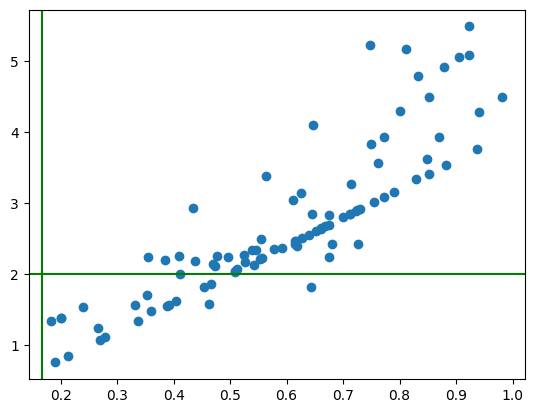

In [53]:
import matplotlib.pyplot as plt
x, y = [], []
for mod in res:
    x.append(mod.signalling_fraction())
    y.append(mod.CbD_direct_influence())
plt.scatter(x, y)
plt.axhline(y=2, color='g', linestyle='-')
plt.axvline(x=1/6, color='g', linestyle='-')
plt.show()